<a href="https://colab.research.google.com/github/Kaaviya-E/Adaptive-HARQ-Scheduling-for-5G-IoT-in-Non-Terrestrial-Networks/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# rf_predict_dd2a_ug2d.py
# Requirements: pandas, numpy, scikit-learn, joblib, matplotlib (optional)
# pip install pandas numpy scikit-learn joblib matplotlib

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

RANDOM_STATE = 42
CSV_PATH = "ntn_harq_dataset.csv"  # change if needed
OUT_MODEL_PATH = "rf_dd2a_ug2d_model.pkl"

# ---------- Helper: find target columns with fallbacks ----------
def find_targets(df):
    candidates = [
        ("n_DD2A", "n_UG2D"),
        ("nDD2A", "nUG2D"),
        ("n_DD2A_j", "n_UG2D_j"),
        ("nDD2A_j", "nUG2D_j"),
    ]
    cols = set(df.columns.str.lower())
    for a, b in candidates:
        if a.lower() in cols and b.lower() in cols:
            # return actual column names (case-sensitive as in df)
            real_a = [c for c in df.columns if c.lower() == a.lower()][0]
            real_b = [c for c in df.columns if c.lower() == b.lower()][0]
            return [real_a, real_b]
    # try direct presence
    if "n_dd2a" in cols and "n_ug2d" in cols:
        return [ [c for c in df.columns if c.lower()=="n_dd2a"][0],
                 [c for c in df.columns if c.lower()=="n_ug2d"][0] ]
    # not found
    raise ValueError(f"Could not find target columns in CSV. Available columns: {list(df.columns)}")

# ---------- 1) Load ----------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print(f"Loaded dataset with shape {df.shape}")

# ---------- 2) Identify targets and features ----------
targets = find_targets(df)  # will raise if not found
print("Target columns detected:", targets)
y = df[targets].copy()
X = df.drop(columns=targets).copy()

# If you have any non-feature columns (ids, timestamps) remove them here:
# X = X.drop(columns=['id','timestamp'], errors='ignore')

# ---------- 3) Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ---------- 4) Preprocessing: numeric vs categorical ----------
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

# transformers
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
    # Note: scaling not necessary for tree-based models
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
], remainder="drop")

# ---------- 5) Model pipeline ----------
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", rf)
])

# ---------- 6) Hyperparameter distribution for RandomizedSearch ----------
param_dist = {
    "regressor__n_estimators": [100, 200, 400, 800],
    "regressor__max_depth": [None, 10, 20, 40, 80],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["sqrt", "log2", 0.5],
}

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=24,
    scoring="r2",
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# ---------- 7) Train ----------
print("Starting RandomizedSearchCV (this may take a while depending on dataset size)...")
rs.fit(X_train, y_train)   # y_train can be a DataFrame with shape (n_samples, 2)

print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# ---------- 8) Evaluate ----------
y_pred = best_model.predict(X_test)

# r2 per target
r2_per_target = r2_score(y_test, y_pred, multioutput="raw_values")
r2_mean = r2_score(y_test, y_pred, multioutput="uniform_average")
mse_per_target = mean_squared_error(y_test, y_pred, multioutput="raw_values")
mae_per_target = mean_absolute_error(y_test, y_pred, multioutput="raw_values")

print("\nEvaluation on test set:")
for i, t in enumerate(targets):
    print(f"  {t} -> R2: {r2_per_target[i]:.4f}, MAE: {mae_per_target[i]:.4f}, MSE: {mse_per_target[i]:.4f}")
print(f"  Mean R2 (averaged across targets): {r2_mean:.4f}")

# ---------- 9) Feature importances (best-effort) ----------
try:
    # retrieve preprocessor components to build feature names
    pre = best_model.named_steps["preprocessor"]
    num_features = numeric_cols
    cat_ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_features = list(cat_ohe.get_feature_names_out(categorical_cols)) if categorical_cols else []
    feature_names = np.array(num_features + cat_features)

    importances = best_model.named_steps["regressor"].feature_importances_
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    print("\nTop 10 feature importances:")
    print(fi_df.head(10).to_string(index=False))
except Exception as e:
    print("Could not compute detailed feature importances automatically:", str(e))

# ---------- 10) Save model ----------
joblib.dump(best_model, OUT_MODEL_PATH)
print(f"\nSaved trained model pipeline to: {OUT_MODEL_PATH}")

# ---------- Example: predict on new raw DataFrame ----------
# loaded_model = joblib.load(OUT_MODEL_PATH)
# new_X = pd.read_csv("/path/to/new_input.csv")
# preds = loaded_model.predict(new_X)  # returns array shape (n_samples, 2)
# preds_df = pd.DataFrame(preds, columns=targets)
# print(preds_df.head())



Loaded dataset with shape (3840, 21)
Target columns detected: ['n_DD2A', 'n_UG2D']
Numeric features: ['altitude_km', 'elevation_deg', 'TBS_bits', 'RTT_ms', 'path_loss_dB', 'SNR_dB', 'n_repetitions', 'N_TBPHC', 'TB_index', 'use_bundling', 'n_bundle', 'SUF_fixed', 'SUF_variable', 'throughput_fixed_bps', 'throughput_variable_bps', 'throughput_gain_percent', 'N_HARQ_required']
Categorical features: ['payload_type', 'direction']
Starting RandomizedSearchCV (this may take a while depending on dataset size)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5, 'regressor__max_depth': None}

Evaluation on test set:
  n_DD2A -> R2: 0.9991, MAE: 0.0331, MSE: 0.0047
  n_UG2D -> R2: 1.0000, MAE: 0.0000, MSE: 0.0000
  Mean R2 (averaged across targets): 0.9996

Top 10 feature importances:
                feature  importance
                N_TB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df.head()

,altitude_km,elevation_deg,TBS_bits,payload_type,RTT_ms,path_loss_dB,SNR_dB,n_repetitions,N_TBPHC,TB_index,...,use_bundling,n_bundle,n_DD2A,n_UG2D,SUF_fixed,SUF_variable,throughput_fixed_bps,throughput_variable_bps,throughput_gain_percent,N_HARQ_required
0,600,10,144,transparent,19.316354,104.189103,30.065401,1,1,1,...,0,1,1,1,0.166667,0.142857,24000,20571.42857,-14.285714,5
1,600,10,144,transparent,19.316354,104.189103,30.065401,1,1,1,...,0,1,1,1,0.125000,0.111111,18000,16000.00000,-11.111111,5
2,600,10,144,transparent,19.316354,104.189103,30.065401,1,1,1,...,1,2,1,1,0.125000,0.111111,18000,16000.00000,-11.111111,5
3,600,10,144,transparent,19.316354,104.189103,30.065401,1,1,1,...,1,4,1,1,0.125000,0.111111,18000,16000.00000,-11.111111,5
4,600,10,144,transparent,19.316354,104.189103,30.065401,1,2,1,...,0,1,2,2,0.166667,0.250000,24000,36000.00000,50.000000,9


Loaded dataset: (3840, 21)
Throughput Model -> R2: 0.9848, MAE: 5973.7126
Saved model as rf_throughput_model.pkl
Delay model expects 21 preprocessed columns.

Top 10 configurations ranked by throughput:
    N_TBPHC  n_repetitions  predicted_throughput_bps  predicted_n_DD2A  \
43        9              4              57553.114476            5.6925   
41        9              2              57553.114476            5.6925   
40        9              1              57553.114476            5.6925   
38        8              4              57553.114476            5.6925   
35        8              1              57553.114476            5.6925   
44        9              5              57553.114476            5.6925   
36        8              2              57553.114476            5.6925   
42        9              3              57553.114476            5.6925   
37        8              3              57553.114476            5.6925   
39        8              5              57553.114476     

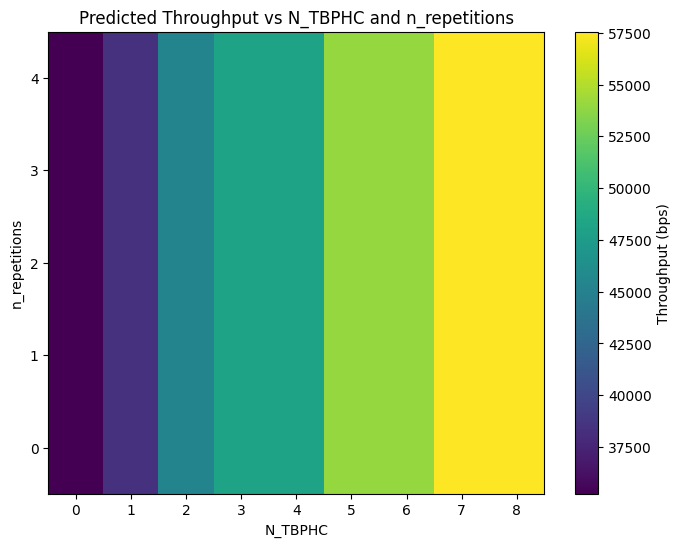


Saved throughput optimization table as throughput_optimization_results.csv


In [ ]:
# ml_optimize_throughput.py
# Requirements: pandas, numpy, scikit-learn, matplotlib, joblib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt

RANDOM_STATE = 42
CSV_PATH = "ntn_harq_dataset.csv"  # your dataset path
DELAY_MODEL_PATH = "rf_dd2a_ug2d_model.pkl"  # the saved delay model from step 1

# ---------- Load Dataset ----------
df = pd.read_csv(CSV_PATH)
print("Loaded dataset:", df.shape)

# ---------- Define features ----------
# Features relevant for throughput prediction
feature_cols = [
    "altitude_km", "elevation_deg", "TBS_bits", "SNR_dB", "RTT_ms",
    "N_TBPHC", "n_repetitions", "n_DD2A", "n_UG2D"
]
target_col = "throughput_variable_bps"  # can change to throughput_fixed_bps if needed

X = df[feature_cols]
y = df[target_col]

# ---------- Split Dataset ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ---------- Train Random Forest ----------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Throughput Model -> R2: {r2:.4f}, MAE: {mae:.4f}")

joblib.dump(rf, "rf_throughput_model.pkl")
print("Saved model as rf_throughput_model.pkl")

# ---------- Optimization: Sweep over N_TBPHC and n_repetitions ----------
# Load your trained delay model
delay_model = joblib.load(DELAY_MODEL_PATH)

# Identify what features the delay model expects
expected_delay_features = delay_model.named_steps["preprocessor"].get_feature_names_out()
print(f"Delay model expects {len(expected_delay_features)} preprocessed columns.")

# We'll use mean/mode values from the dataset for the non-swept features
mean_values = df.mean(numeric_only=True)
mode_values = df.mode().iloc[0]

n_tbphc_range = np.arange(1, 10, 1)
n_rep_range = np.arange(1, 6, 1)

results = []
for tbphc in n_tbphc_range:
    for reps in n_rep_range:
        # start with base features
        X_input = pd.DataFrame([{
            "altitude_km": mean_values["altitude_km"],
            "elevation_deg": mean_values["elevation_deg"],
            "TBS_bits": mean_values["TBS_bits"],
            "RTT_ms": mean_values["RTT_ms"],
            "path_loss_dB": mean_values["path_loss_dB"],
            "SNR_dB": mean_values["SNR_dB"],
            "n_repetitions": reps,
            "N_TBPHC": tbphc,
            "TB_index": mean_values["TB_index"],
            "use_bundling": int(round(mean_values["use_bundling"])),
            "n_bundle": mean_values["n_bundle"],
            "SUF_fixed": mean_values["SUF_fixed"],
            "SUF_variable": mean_values["SUF_variable"],
            "throughput_fixed_bps": mean_values["throughput_fixed_bps"],
            "throughput_variable_bps": mean_values["throughput_variable_bps"],
            "throughput_gain_percent": mean_values["throughput_gain_percent"],
            "N_HARQ_required": mean_values["N_HARQ_required"],
            "payload_type": mode_values["payload_type"],
            "direction": mode_values["direction"]
        }])

        # Predict delay using the trained model
        delay_preds = delay_model.predict(X_input)
        X_input["n_DD2A"], X_input["n_UG2D"] = delay_preds[0]

        # Predict throughput
        throughput_pred = rf.predict(X_input[feature_cols])[0]

        results.append({
            "N_TBPHC": tbphc,
            "n_repetitions": reps,
            "predicted_throughput_bps": throughput_pred,
            "predicted_n_DD2A": X_input["n_DD2A"].values[0],
            "predicted_n_UG2D": X_input["n_UG2D"].values[0],
        })

results_df = pd.DataFrame(results)
results_df["throughput_gain_%"] = (
    100 * (results_df["predicted_throughput_bps"] - results_df["predicted_throughput_bps"].min())
    / results_df["predicted_throughput_bps"].min()
)

print("\nTop 10 configurations ranked by throughput:")
print(results_df.sort_values("predicted_throughput_bps", ascending=False).head(10))

# ---------- Plot Results ----------
pivot = results_df.pivot(index="n_repetitions", columns="N_TBPHC", values="predicted_throughput_bps")

plt.figure(figsize=(8,6))
plt.title("Predicted Throughput vs N_TBPHC and n_repetitions")
plt.xlabel("N_TBPHC")
plt.ylabel("n_repetitions")
plt.imshow(pivot, origin="lower", cmap="viridis", aspect="auto")
plt.colorbar(label="Throughput (bps)")
plt.show()

results_df.to_csv("throughput_optimization_results.csv", index=False)
print("\nSaved throughput optimization table as throughput_optimization_results.csv")



📊 Throughput Optimization Summary
-------------------------------------------------------
Baseline (N_TBPHC=1, n_repetitions=1): 35246.76 bps
Optimal Configuration: N_TBPHC=8.0, n_repetitions=1.0
Optimal Throughput: 57553.11 bps
Predicted n_DD2A delay: 5.6925
Predicted n_UG2D delay: 6.1662
Throughput Gain: 63.29%


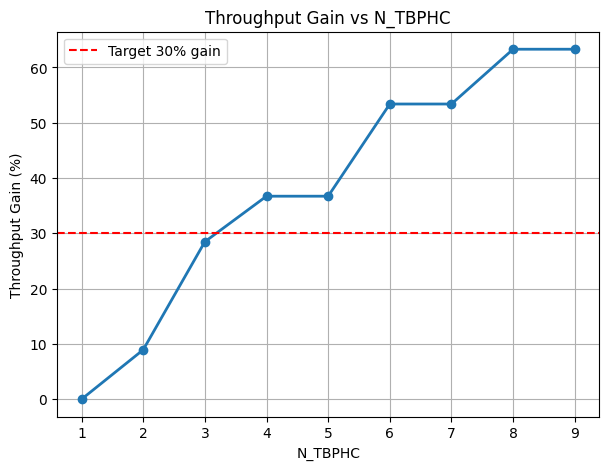

In [ ]:
# ---------- Throughput Optimization & Gain Analysis ----------

# Define baseline (usually N_TBPHC=1, n_repetitions=1)
baseline = results_df[(results_df["N_TBPHC"] == 1) & (results_df["n_repetitions"] == 1)]
if baseline.empty:
    baseline_throughput = results_df["predicted_throughput_bps"].min()
    print("Baseline combination not found, using minimum throughput as baseline.")
else:
    baseline_throughput = baseline["predicted_throughput_bps"].values[0]

# Find optimal configuration
opt_idx = results_df["predicted_throughput_bps"].idxmax()
opt_config = results_df.loc[opt_idx]
opt_throughput = opt_config["predicted_throughput_bps"]

# Compute throughput gain (%)
gain_percent = ((opt_throughput - baseline_throughput) / baseline_throughput) * 100

print("\n📊 Throughput Optimization Summary")
print("-------------------------------------------------------")
print(f"Baseline (N_TBPHC=1, n_repetitions=1): {baseline_throughput:.2f} bps")
print(f"Optimal Configuration: N_TBPHC={opt_config['N_TBPHC']}, n_repetitions={opt_config['n_repetitions']}")
print(f"Optimal Throughput: {opt_throughput:.2f} bps")
print(f"Predicted n_DD2A delay: {opt_config['predicted_n_DD2A']:.4f}")
print(f"Predicted n_UG2D delay: {opt_config['predicted_n_UG2D']:.4f}")
print(f"Throughput Gain: {gain_percent:.2f}%")

# ---------- Plot Throughput Gain vs N_TBPHC ----------
avg_throughput_by_tbphc = results_df.groupby("N_TBPHC")["predicted_throughput_bps"].mean()
gain_vs_tbphc = 100 * (avg_throughput_by_tbphc - baseline_throughput) / baseline_throughput

plt.figure(figsize=(7,5))
plt.plot(gain_vs_tbphc.index, gain_vs_tbphc.values, marker="o", linewidth=2)
plt.axhline(30, color="r", linestyle="--", label="Target 30% gain")
plt.title("Throughput Gain vs N_TBPHC")
plt.xlabel("N_TBPHC")
plt.ylabel("Throughput Gain (%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Limit N_TBPHC range to match paper's range, e.g. up to 4
filtered = results_df[results_df["N_TBPHC"] <= 4]
baseline = filtered[(filtered["N_TBPHC"] == 1) & (filtered["n_repetitions"] == 1)]["predicted_throughput_bps"].values[0]
opt = filtered["predicted_throughput_bps"].max()
gain = 100 * (opt - baseline) / baseline
print(f"Gain limited to N_TBPHC<=4: {gain:.2f}%")


Gain limited to N_TBPHC<=4: 36.71%


In [ ]:
# step1_sanity_check.py
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

CSV = "ntn_harq_dataset.csv"    # path you provided
DELAY_MODEL = "rf_dd2a_ug2d_model.pkl"

if not os.path.exists(CSV):
    raise FileNotFoundError(CSV)

df = pd.read_csv(CSV)
print("Loaded", CSV, "shape=", df.shape)
print("Columns:", df.columns.tolist()[:50])

# Quick column checks
print("\n--- Missing values (top) ---")
print(df.isna().sum().sort_values(ascending=False).head(20))

# Look for DD2A/UG2D columns used by your code
candidates = ["n_DD2A","n_UG2D","nDD2A","nUG2D","n_DD2A_j","n_UG2D_j"]
found = [c for c in df.columns if c in candidates or c.lower() in [x.lower() for x in candidates]]
print("\nPotential target cols found:", found)

# If saved model exists, load and run a single predict; otherwise train a quick model
if os.path.exists(DELAY_MODEL):
    model = joblib.load(DELAY_MODEL)
    print("Loaded delay model:", DELAY_MODEL)
    # construct a single-row input with mean/mode for non-target features
    features = [c for c in df.columns if c not in found]
    example = df[features].select_dtypes(include=[np.number]).mean().to_frame().T
    # For categorical features, use mode
    cat_cols = [c for c in features if c not in example.columns]
    for c in cat_cols:
        example[c] = df[c].mode().iloc[0]
    preds = model.predict(example)
    print("Example prediction (DD2A, UG2D):", preds)
else:
    # Quick training fallback: pick numeric columns, tiny RF to ensure pipeline works
    # This is only to get a callable model if you don't have the saved model.
    target_cols = [c for c in df.columns if c.lower() in ("n_dd2a","n_ug2d","ndd2a","nug2d")]
    if len(target_cols) < 2:
        raise ValueError("Could not find both target columns for DD2A/UG2D. Found: " + str(target_cols))
    X = df.drop(columns=target_cols).select_dtypes(include=[np.number]).fillna(0)
    y = df[target_cols].fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    joblib.dump(rf, DELAY_MODEL)
    print("Trained and saved quick delay model:", DELAY_MODEL)
    print("Sample preds:", rf.predict(X_test.iloc[:3]))


Loaded ntn_harq_dataset.csv shape= (3840, 21)
Columns: ['altitude_km', 'elevation_deg', 'TBS_bits', 'payload_type', 'RTT_ms', 'path_loss_dB', 'SNR_dB', 'n_repetitions', 'N_TBPHC', 'TB_index', 'direction', 'use_bundling', 'n_bundle', 'n_DD2A', 'n_UG2D', 'SUF_fixed', 'SUF_variable', 'throughput_fixed_bps', 'throughput_variable_bps', 'throughput_gain_percent', 'N_HARQ_required']

--- Missing values (top) ---
altitude_km                0
elevation_deg              0
TBS_bits                   0
payload_type               0
RTT_ms                     0
path_loss_dB               0
SNR_dB                     0
n_repetitions              0
N_TBPHC                    0
TB_index                   0
direction                  0
use_bundling               0
n_bundle                   0
n_DD2A                     0
n_UG2D                     0
SUF_fixed                  0
SUF_variable               0
throughput_fixed_bps       0
throughput_variable_bps    0
throughput_gain_percent    0
dtype: int6

In [ ]:
# after prediction, make a CSV the simulator will read:
example["pred_n_DD2A"] = int(round(preds[0][0]))  # adapt shape as needed
example["pred_n_UG2D"] = int(round(preds[0][1]))
example.to_csv("example_delay_inputs_and_preds.csv", index=False)


In [ ]:
!pip install simpy

Loading dataset and model...
Dataset shape: (3840, 21)
Loaded delay model: rf_dd2a_ug2d_model.pkl
Sim finished in wall time: 42.33199882507324 s
Total packets: 200, Succeeded: 200, Success rate: 1.000, Avg attempts: 1.045
Saved harq_sim_results.csv
Saved harq_attempts_hist.png


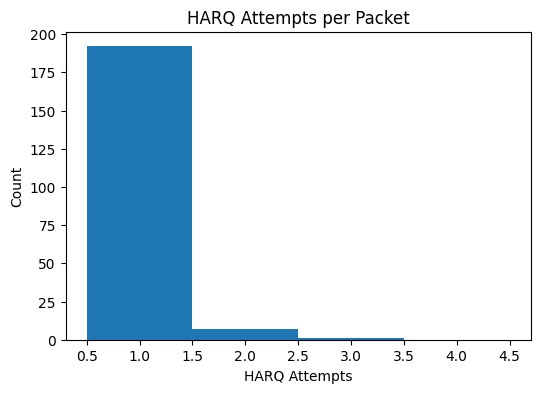

In [ ]:
# harq_sim_with_predictor.py
import simpy
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ------------ USER CONFIG -------------
CSV = "ntn_harq_dataset.csv"                 # your dataset (used to sample mean/mode features)
DELAY_MODEL_PATH = "rf_dd2a_ug2d_model.pkl"  # trained predictor (from Step 1)
NUM_PACKETS = 200                            # how many packets to simulate
PACKET_INTERVAL_MS = 10                      # time between packet transmissions from BS (ms)
MAX_RETX = 3                                 # max HARQ retransmissions (not infinite)
HARQ_TIMEOUT_MS = 200                        # HARQ timeout guard (ms) - will be compared to predicted ack arrival
PROPAGATION_DELAY_MS = 10                    # fixed propagation one-way (ms) if RTT not available
USE_RTT_IF_PRESENT = True                    # if dataset has RTT_ms use it
ASSUME_PRED_IN_MS = True                     # if model predicts in ms. If predictions in subframes, adjust conversion
PACKET_LOSS_PROB = 0.05                      # physical packet loss probability at UE per transmission
RANDOM_SEED = 42
# ---------------------------------------

np.random.seed(RANDOM_SEED)

# -------- Helper: prepare a per-packet feature row for predictor ----------
def make_feature_row(base_df_mean, base_df_mode, tbphc=None, reps=None):
    """
    Build a 1-row DataFrame with required features for the predictor.
    We use mean for numeric columns and mode for categorical, with optional overrides.
    Add or override columns as needed by your model's expected inputs.
    """
    row = base_df_mean.copy()   # pandas Series
    # fill categorical features with mode values from dataset
    for c in base_df_mode.index:
        if c not in row.index:
            row.loc[c] = base_df_mode[c]
    # allow small randomization to simulate dynamics
    # example: jitter RTT or SNR a bit
    if "RTT_ms" in row.index:
        row["RTT_ms"] = max(1.0, row["RTT_ms"] * (1 + np.random.normal(0, 0.05)))
    if "SNR_dB" in row.index:
        row["SNR_dB"] = row["SNR_dB"] + np.random.normal(0, 1.0)
    if tbphc is not None:
        row["N_TBPHC"] = tbphc
    if reps is not None:
        row["n_repetitions"] = reps
    # ensure proper dtypes
    return pd.DataFrame([row])

# ---------- Load model and dataset ----------
print("Loading dataset and model...")
df = pd.read_csv(CSV)
print("Dataset shape:", df.shape)
# compute numeric mean and categorical mode for default inputs
numeric_means = df.select_dtypes(include=[np.number]).mean()
modes = df.mode().iloc[0] if not df.mode().empty else pd.Series(dtype=object)

# load predictor (pipeline)
delay_model = joblib.load(DELAY_MODEL_PATH)
print("Loaded delay model:", DELAY_MODEL_PATH)

# helper to predict safely (handles 1D and 2D outputs)
def predict_dd2a_ug2d(model, X_row):
    pred = model.predict(X_row)  # may be array shape (1,2) or (2,) or list
    arr = np.asarray(pred)
    if arr.ndim == 1:
        # could be length-2 vector
        if arr.size == 2:
            return float(arr[0]), float(arr[1])
        else:
            raise ValueError("Predictor returned 1D output with unexpected length: " + str(arr.shape))
    elif arr.ndim == 2:
        if arr.shape[1] >= 2:
            return float(arr[0,0]), float(arr[0,1])
        else:
            raise ValueError("Predictor returned 2D output with <2 columns: " + str(arr.shape))
    else:
        raise ValueError("Unexpected prediction shape: " + str(arr.shape))

# ---------- SimPy processes ----------
class HARQSim:
    def __init__(self, env, delay_model, df_mean, df_mode):
        self.env = env
        self.delay_model = delay_model
        self.df_mean = df_mean
        self.df_mode = df_mode
        self.stats = defaultdict(list)
        self.packet_count = 0

    def bs_send_packets(self, num_packets, interval_ms):
        """BS process that sends packets at regular intervals"""
        for i in range(num_packets):
            self.packet_count += 1
            pkt_id = self.packet_count
            self.env.process(self.handle_packet(pkt_id))
            yield self.env.timeout(interval_ms/1000.0)  # convert ms -> s

    def handle_packet(self, pkt_id):
        """Simulate the full HARQ exchange for a single packet"""
        send_time = self.env.now  # seconds
        attempts = 0
        success = False
        while attempts <= MAX_RETX and not success:
            attempts += 1
            # log send
            # simulate propagation: bs -> ue (one-way)
            # Use RTT_ms from mean if available, else PROPAGATION_DELAY_MS
            if USE_RTT_IF_PRESENT and "RTT_ms" in self.df_mean.index:
                prop_ms = float(self.df_mean["RTT_ms"])/2.0
            else:
                prop_ms = PROPAGATION_DELAY_MS
            # time for UE to receive the packet
            ue_receive_delay_s = prop_ms/1000.0
            yield self.env.timeout(ue_receive_delay_s)

            # physical packet loss: maybe UE didn't decode -> no ACK
            phys_loss = np.random.rand() < PACKET_LOSS_PROB
            if phys_loss:
                # UE fails to decode and won't send ACK (or sends NACK, but we treat as no ACK)
                # schedule nothing and let BS wait for HARQ timeout
                ack_expected = False
                predicted_total_delay_s = None
            else:
                # build feature row for prediction (you can customize which columns)
                # Optionally vary tbphc and reps across attempts
                feats = make_feature_row(self.df_mean, self.df_mode)
                # call predictor
                try:
                    n_dd2a, n_ug2d = predict_dd2a_ug2d(self.delay_model, feats)
                except Exception as e:
                    print("Prediction error at time", self.env.now, "err:", e)
                    n_dd2a, n_ug2d = float(self.df_mean.get("n_DD2A", 10)), float(self.df_mean.get("n_UG2D", 10))
                # ensure non-negative
                n_dd2a = max(0.0, n_dd2a)
                n_ug2d = max(0.0, n_ug2d)
                # total round-trip additional processing delay at UE+uplink (ms)
                # depending on your model, DD2A could be downlink decode delay and UG2D uplink delay
                # A simple mapping: ACK_arrival_time = now + n_DD2A + n_UG2D + prop_back
                # we already advanced time to when UE received packet
                # add UE internal processing (n_ug2d) and UL propagation (prop_ms) and any additional n_dd2a if needed
                # Here we compute ACK arrival from current env.now:
                # convert ms->s
                predicted_total_delay_s = (n_dd2a + n_ug2d + prop_ms)/1000.0
                ack_expected = True

            # BS waits for ACK or timeout (HARQ timer)
            # We simulate waiting: either ACK event occurs after predicted_total_delay_s or not
            if ack_expected and predicted_total_delay_s is not None:
                # yield a timeout representing ACK arrival
                # but if predicted_total_delay_s > HARQ timeout, BS will timeout first -> retransmit
                # use min to decide ordering
                if predicted_total_delay_s <= HARQ_TIMEOUT_MS/1000.0:
                    # ACK arrives in time
                    yield self.env.timeout(predicted_total_delay_s)
                    success = True
                    self.stats["packet"].append(pkt_id)
                    self.stats["attempts"].append(attempts)
                    self.stats["success_time_s"].append(self.env.now - send_time)
                    break
                else:
                    # predicted ACK arrival after HARQ timeout -> BS will retransmit at timeout
                    yield self.env.timeout(HARQ_TIMEOUT_MS/1000.0)
                    # loop continues for retransmission
            else:
                # no ack_expected (physical loss) -> wait for HARQ timeout then retransmit
                yield self.env.timeout(HARQ_TIMEOUT_MS/1000.0)
                # continue loop -> retransmit if attempts left

        # after loop
        if not success:
            self.stats["packet"].append(pkt_id)
            self.stats["attempts"].append(attempts)
            self.stats["success_time_s"].append(None)  # failed

# ---------- Run simulation ----------
env = simpy.Environment()
sim = HARQSim(env, delay_model, numeric_means, modes)
env.process(sim.bs_send_packets(NUM_PACKETS, PACKET_INTERVAL_MS))
start_wall = time.time()
env.run()   # run until no events
print("Sim finished in wall time:", time.time() - start_wall, "s")

# ---------- Report ----------
results_df = pd.DataFrame({
    "packet": sim.stats["packet"],
    "attempts": sim.stats["attempts"],
    "success_time_s": sim.stats["success_time_s"]
})
total = len(results_df)
succeeded = results_df["success_time_s"].notna().sum()
avg_attempts = results_df["attempts"].mean()
print(f"Total packets: {total}, Succeeded: {succeeded}, Success rate: {succeeded/total:.3f}, Avg attempts: {avg_attempts:.3f}")

# Save CSV and simple plot
results_df.to_csv("harq_sim_results.csv", index=False)
print("Saved harq_sim_results.csv")

# histogram of attempts
plt.figure(figsize=(6,4))
plt.hist(results_df["attempts"].dropna(), bins=np.arange(1, MAX_RETX+3)-0.5)
plt.xlabel("HARQ Attempts")
plt.ylabel("Count")
plt.title("HARQ Attempts per Packet")
plt.savefig("harq_attempts_hist.png")
print("Saved harq_attempts_hist.png")
